# Polynomial regression 

The example belows uses a temperature-energy dataset in order to illustrate how to perform a non linear regression.

Workflow:
1. Preparation
    - Extract the dataset from the _power_demand_vs_temperature.csv_ 
    - Explore the dataset and check for missing values
    - Plot the distribution
    - Divide the dataset into train and test 
    - Create an evaluation function
2. First experiment
    - Create a linear model 
    - Train the model on X_train and y_train
    - Evaluate the model on X_test and y_test
    - Visualize the prediction of the model
3. Second experiment
    - Create a polynomial regression model with degree 2
    - Train the model on X_train and y_train
    - Evaluate the model on X_test and y_test
    - Visualize the prediction of the model
4. Third experiment
    - repeat the steps done in the second experiment but with degree 3
5. Third experiment
    - repeat the steps done in the second experiment but with degree 4
6. Compare the evaluation of each model


In [1]:
# Code source: Filippo Orazi 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

random_state = 42 # this will be used to guarantee the repeatability of the experiment

## Dataset preparation

### Load the dataset from a `.csv` file
This cell allows full compatibility between execution in Google Colab and in local


In [2]:
try:
  import google.colab.files
  IN_COLAB = True
except:
  IN_COLAB = False
# from google.colab import files
if IN_COLAB:
    uploaded = files.upload()


The file must be available in the same directory, or uploaded in the Colab environment in the execution of the previous cell


Set the date column as index

In [3]:
data_fn = 'power_demand_vs_temperature.csv'
df0 = pd.read_csv(data_fn, index_col=0)
df0.head()

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0


### Explore the dataset and check for missing values


In [4]:
df0.describe(include='all')

,demand,temp
count,1096.000000,1096.000000
mean,1.831796,16.927737
std,0.329434,10.791581
min,1.316033,-15.000000
25%,1.581654,8.900000
50%,1.731479,18.900000
75%,2.024869,26.100000
max,2.804025,33.900000


In [5]:
print(f"The dataframe has {df0.shape[0]-df0.dropna().shape[0]} invalid rows")

The dataframe has 0 invalid rows


### Create X and y 

In [6]:
X = df0.drop("demand", axis=1)
y = df0["demand"]
print(f"X has shape{X.shape}")
print(f"Y has shape{y.shape}")

X has shape(1096, 1)
Y has shape(1096,)


### Plot the distribution



In [7]:
import warnings
warnings.filterwarnings("ignore")

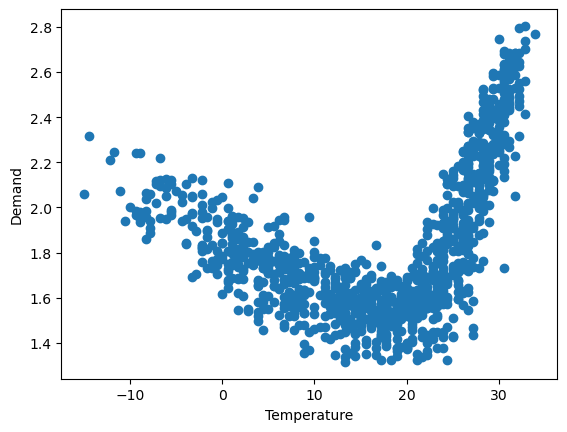

In [8]:
plt.scatter(X,y)
plt.xlabel("Temperature");
plt.ylabel("Demand");
plt.show()

### Divide the dataset in train test split

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=random_state, train_size=0.7)
print('Training set and test set have {} and {} elements respectively'.format(X_train.shape[0],X_test.shape[0]))

Training set and test set have 767 and 329 elements respectively


### Create an evaluation function to compute, print and return the metrics: rmse r2 f-statistic and p-value

In [10]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm
def f_test(y_true, y_pred, n_var, n_obs, sn=.95):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = n_obs
    p = n_var+1 # number of regression parameters (coefficients + intercept)
    y_true_m = np.mean(y_true)
    SSM = np.sum((y_pred-y_true_m)**2)
    SST = np.sum((y_true-y_true_m)**2)
    SSE = np.sum((y_true-y_pred)**2)
    DFT = n - 1
    DFM = p - 1 # degrees of freedom for model - numerator
    DFE = n - p # degrees of freedom for error - denominator
    DFT = n - 1
    MSM = SSM / DFM
    MSE = SSE / DFE 
    MST = SST / DFT
    F = MSM / MSE
    # f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    p = 1-scipy.stats.f.cdf(F, DFM, DFE) #find p-value of F test statistic 
    return F, p

def print_eval(X, y, model):
    pred = model.predict(X)
    F, p = f_test(y, pred, X.shape[1], X.shape[0])
    print(" Mean squared error: \t{:.5}".format(mean_squared_error(y,pred)))
    print(" r2 score: \t\t{:.5}".format(r2_score(y,pred)))
    print(" f-statistic: \t\t{:.5}".format(F))
    print(" p-value: \t\t{:.5}".format(p))
    return mean_squared_error(pred, y), r2_score(pred, y), F, p


## First experiment
Create a linear model 

Train the model on X_train and y_train 

Evaluate the model on X_test and y_test


In [11]:
lmodel = LinearRegression()
lmodel.fit(X.temp.values.reshape(-1,1), y)
lin = print_eval(X_test, y_test, lmodel)

 Mean squared error: 	0.10016
 r2 score: 		0.1803
 f-statistic: 		53.273
 p-value: 		2.2197e-12


#### Visualize the prediction of the model 

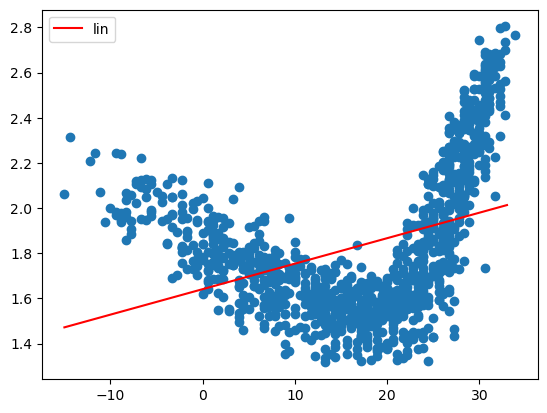

In [12]:
lpred = lmodel.predict(np.arange(min(X.temp), max(X.temp)).reshape(-1,1))
plt.plot(np.arange(min(X.temp), max(X.temp)),lpred, label = "lin", color = "red")
plt.legend()
plt.scatter(X,y)
plt.show();

## Second experiment - Polynomial regression
We can clearly see that the linear regression model cannot really approximate the data distribution.

We can now try with a non linear regression model:
1. Use the sklearn fucntion _PolynomialFeature_ to create a new array of features. Set _degree=2_ and _include_bias=False_
2. Train a Linear regression model with the new features
3. Evaluate the model 
4. Visualize the predicted values of the model

#### Polynomial degree = 2

In [13]:
polFea = PolynomialFeatures(2,include_bias=False)
X_poly = polFea.fit_transform(X_train.values)#.reshape(-1,1))
model = LinearRegression()
model.fit(X_poly, y_train)


LinearRegression()

In [14]:
pol = print_eval(polFea.transform(X_test), y_test, model)

 Mean squared error: 	0.033456
 r2 score: 		0.72619
 f-statistic: 		384.89
 p-value: 		1.1102e-16


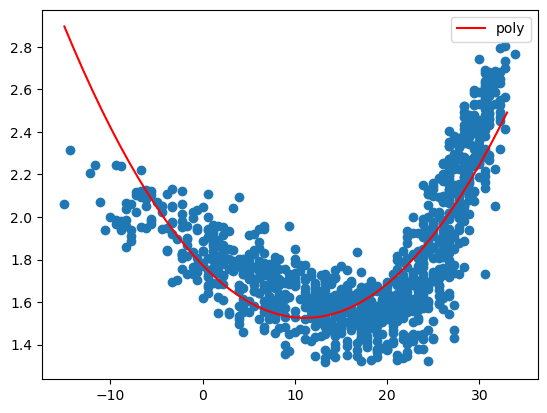

In [15]:
pred = model.predict(polFea.transform((np.arange(min(X.temp), max(X.temp))).reshape(-1,1)))
plt.plot(np.arange(min(X.temp), max(X.temp)),pred, label = "poly",color="red")
plt.legend()
plt.scatter(X,y)
plt.plot();

## Third experiment

#### Polynomial degree = 3

In [16]:
polFea = PolynomialFeatures(3,include_bias=False)
print("Polynomial degree = 3")
X_poly = polFea.fit_transform(X_train.values)#.reshape(-1,1))
model = LinearRegression()
model.fit(X_poly, y_train)


Polynomial degree = 3


LinearRegression()

In [17]:
pol3 = print_eval(polFea.transform(X_test), y_test, model)

 Mean squared error: 	0.021749
 r2 score: 		0.822
 f-statistic: 		502.32
 p-value: 		1.1102e-16


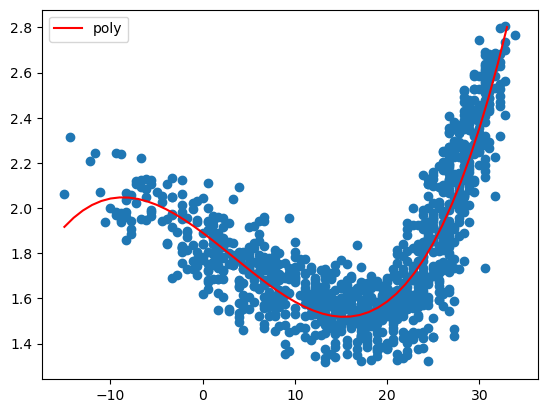

In [18]:
pred3 = model.predict(polFea.transform((np.arange(min(X.temp), max(X.temp))).reshape(-1,1)))
plt.plot(np.arange(min(X.temp), max(X.temp)),pred3, label = "poly",color="red")
plt.legend()
plt.scatter(X,y)
plt.plot();

## Fourth experiment
### Polynomial degree = 4

In [19]:
polFea = PolynomialFeatures(4,include_bias=False)
print("Polynomial degree = 4")
X_poly = polFea.fit_transform(X_train.values)#.reshape(-1,1))
model = LinearRegression()
model.fit(X_poly, y_train)


Polynomial degree = 4


LinearRegression()

In [20]:
pol4 = print_eval(polFea.transform(X_test), y_test, model)

 Mean squared error: 	0.021334
 r2 score: 		0.8254
 f-statistic: 		390.05
 p-value: 		1.1102e-16


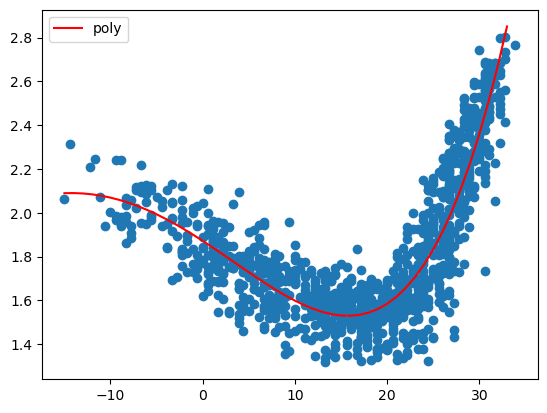

In [21]:
pred4 = model.predict(polFea.transform((np.arange(min(X.temp), max(X.temp))).reshape(-1,1)))
plt.plot(np.arange(min(X.temp), max(X.temp)),pred4, label = "poly",color="red")
plt.legend()
plt.scatter(X,y)
plt.plot();

## Compare the performance of the four models

In [22]:
performance = {"linear ": [*lin],
                "polynomial d = 2": [*pol],
                "polynomial d = 3": [*pol3],
                "polynomial d = 4": [*pol4] }
res = pd.DataFrame(performance, index = ['rmse'
                     , 'r2'
                     , 'f-statistic'
                     , 'p-value'])
res

,linear,polynomial d = 2,polynomial d = 3,polynomial d = 4
rmse,1.001591e-01,3.345625e-02,2.174942e-02,2.133387e-02
r2,-5.366169e+00,5.756325e-01,7.843318e-01,7.923317e-01
f-statistic,5.327309e+01,3.848865e+02,5.023183e+02,3.900454e+02
p-value,2.219669e-12,1.110223e-16,1.110223e-16,1.110223e-16
